# Model 8 implementation in BTC and ETH

## Model Equation 

In [1]:
# Imports
import numpy as np
import pandas as pd
from pycoingecko import CoinGeckoAPI
import particles
from particles import state_space_models as ssm
from particles import distributions as dists
from particles.core import SMC
import scipy.stats as stats
from scipy.special import loggamma
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import pickle
from typing import Tuple, Dict, List, Optional

warnings.filterwarnings('ignore')


In [2]:
# =============================================================================
# Custom Distribution Classes
# =============================================================================

class AugmentedState(dists.ProbDist):
    """Distribution for augmented state (h_t, u_t)."""
    
    def __init__(self, h_dist, u_dist):
        self.h_dist = h_dist
        self.u_dist = u_dist
    
    def rvs(self, size=None):
        if size is None:
            h = self.h_dist.rvs()
            u = self.u_dist.rvs()
            return np.array([h, u])
        else:
            h = self.h_dist.rvs(size=size)
            u = self.u_dist.rvs(size=size)
            return np.column_stack([h, u])
    
    def logpdf(self, x):
        if x.ndim == 1:
            return self.h_dist.logpdf(x[0]) + self.u_dist.logpdf(x[1])
        else:
            return self.h_dist.logpdf(x[:, 0]) + self.u_dist.logpdf(x[:, 1])


class StudentT(dists.ProbDist):
    """Student-t distribution wrapper for particles."""
    
    def __init__(self, df, loc=0.0, scale=1.0):
        self.df = df
        self.loc = loc
        self.scale = scale
    
    def rvs(self, size=None):
        return stats.t.rvs(df=self.df, loc=self.loc, scale=self.scale, size=size)
    
    def logpdf(self, x):
        return stats.t.logpdf(x, df=self.df, loc=self.loc, scale=self.scale)


class MultiObservationDist(dists.ProbDist):
    """Distribution for batch observation likelihood."""
    
    def __init__(self, model, t, x):
        self.model = model
        self.t = t
        self.x = x
        self.y_t = model.data.iloc[t].values
    
    def logpdf(self, y):
        # Note: y argument is ignored as we condition on observed data
        N = self.x.shape[0]
        log_liks = np.zeros(N)
        
        for i in range(N):
            h_t, u_t = self.x[i, 0], self.x[i, 1]
            f_t = np.exp(h_t / 2) * u_t
            mean = self.model.D * f_t
            
            log_liks[i] = (
                stats.t.logpdf(self.y_t[0], df=self.model.nu1, 
                              loc=mean[0], scale=self.model.sigma_e1) +
                stats.t.logpdf(self.y_t[1], df=self.model.nu2, 
                              loc=mean[1], scale=self.model.sigma_e2)
            )
        
        return log_liks

In [3]:
# =============================================================================
# Main Model Class
# =============================================================================

class AFactorTMSV(ssm.StateSpaceModel):
    """Augmented Factor-t-MSV model with proper state space representation."""
    
    def __init__(self, data, mu=0.0, phi=0.98, sigma=0.15, d=0.5, 
                 sigma_e1=0.1, sigma_e2=0.1, nu1=5.0, nu2=5.0, omega=5.0):
        self.data = data
        self.T = len(data)
        self.n_assets = data.shape[1]
        
        # Model parameters
        self.mu = mu
        self.phi = phi
        self.sigma = sigma
        self.d = d
        self.sigma_e1 = sigma_e1
        self.sigma_e2 = sigma_e2
        self.nu1 = nu1
        self.nu2 = nu2
        self.omega = omega
        
        # Factor loadings matrix D
        self.D = np.array([1.0, d])
    
    def PX0(self):
        """Initial distribution for augmented state (h_0, u_0)."""
        # Stationary distribution for h_0
        h0_dist = dists.Normal(
            loc=self.mu, 
            scale=self.sigma / np.sqrt(1 - self.phi**2)
        )
        # Initial u_0 ~ t(0, 1, omega)
        u0_dist = StudentT(df=self.omega, loc=0.0, scale=1.0)
        
        return AugmentedState(h0_dist, u0_dist)
    
    def PX(self, t, xp):
        """State transition: (h_t, u_t) | (h_{t-1}, u_{t-1})."""
        if xp.ndim == 1:
            h_prev = xp[0]
        else:
            h_prev = xp[:, 0]
        
        # h_t | h_{t-1} ~ N(mu + phi*(h_{t-1} - mu), sigma^2)
        h_t_dist = dists.Normal(
            loc=self.mu + self.phi * (h_prev - self.mu),
            scale=self.sigma
        )
        
        # u_t ~ t(0, 1, omega) (independent of past)
        u_t_dist = StudentT(df=self.omega, loc=0.0, scale=1.0)
        
        return AugmentedState(h_t_dist, u_t_dist)
    
    def PY(self, t, xp, x):
        """Observation likelihood: p(y_t | h_t, u_t)."""
        # Handle both single particle and batch of particles
        if x.ndim == 1:
            return self._single_observation_loglik(t, x)
        else:
            # For batch processing
            return MultiObservationDist(self, t, x)
    
    def _single_observation_loglik(self, t, x):
        """Calculate log-likelihood for a single particle."""
        h_t, u_t = x[0], x[1]
        y_t = self.data.iloc[t].values
        
        # Factor: f_t = exp(h_t/2) * u_t
        f_t = np.exp(h_t / 2) * u_t
        
        # Mean: E[y_t | h_t, u_t] = D * f_t
        mean = self.D * f_t
        
        # Calculate log-likelihood for each component
        log_lik1 = stats.t.logpdf(
            y_t[0], df=self.nu1, loc=mean[0], scale=self.sigma_e1
        )
        log_lik2 = stats.t.logpdf(
            y_t[1], df=self.nu2, loc=mean[1], scale=self.sigma_e2
        )
        
        return log_lik1 + log_lik2



In [47]:
# =============================================================================
# Data Processing Functions
# =============================================================================

def fetch_crypto_prices(coins=['bitcoin', 'ethereum'], days=365, vs_currency='usd'):
    """Fetch cryptocurrency price data from CoinGecko."""
    cg = CoinGeckoAPI()
    data = {}
    
    for coin in coins:
        try:
            market_data = cg.get_coin_market_chart_by_id(
                id=coin, vs_currency=vs_currency, days=days
            )
            prices = [x[1] for x in market_data['prices']]
            timestamps = [pd.to_datetime(x[0], unit='ms') for x in market_data['prices']]
            data[coin] = pd.Series(prices, index=timestamps)
        except Exception as e:
            print(f"Error fetching {coin} data: {e}")
            return None
    
    df = pd.DataFrame(data)
    df.columns = [c.upper() for c in df.columns]
    return df.dropna()


def compute_log_returns(df):
    """Compute centered log-returns from price data."""
    log_prices = np.log(df)
    log_returns = log_prices.diff().dropna()
    log_returns -= log_returns.mean()  # Center returns
    return log_returns


# =============================================================================
# Particle Filter Functions
# =============================================================================

def run_particle_filter(model, n_particles=1000, seed=42):
    """Run particle filter with the augmented state space model."""
    # Create the bootstrap filter
    fk_model = ssm.Bootstrap(ssm=model, data=model.data.values)
    
    # Run SMC
    pf = SMC(fk=fk_model, N=n_particles, resampling='systematic')
    pf.run()
    
    return pf


def extract_states(pf):
    """Extract filtered states from particle filter output."""
    # The issue: pf.X might contain all particles for the last time step
    # instead of filtered states over time
    
    # Check if we have history of states
    if hasattr(pf, 'hist') and hasattr(pf.hist, 'X'):
        # Use historical states
        T = len(pf.hist.X)
        h_filtered = np.zeros(T)
        u_filtered = np.zeros(T)
        h_std = np.zeros(T)
        
        for t in range(T):
            particles = pf.hist.X[t]
            
            # Get weights
            if hasattr(pf.hist, 'wgts') and len(pf.hist.wgts) > t:
                weights = pf.hist.wgts[t].W
            else:
                weights = np.ones(len(particles)) / len(particles)
            
            # Process particles
            particles = np.asarray(particles)
            weights = np.asarray(weights).flatten()
            
            if particles.ndim == 2 and particles.shape[1] == 2:
                h_particles = particles[:, 0]
                u_particles = particles[:, 1]
            else:
                h_particles = particles.flatten()
                u_particles = np.zeros_like(h_particles)
            
            # Weighted statistics
            h_filtered[t] = np.dot(h_particles, weights)
            u_filtered[t] = np.dot(u_particles, weights)
            h_var = np.dot((h_particles - h_filtered[t])**2, weights)
            h_std[t] = np.sqrt(h_var)
            
    else:
        # Fallback: we only have final particles
        # This means we need to re-run the filter with collection enabled
        print("Warning: Particle history not available. Using final state only.")
        
        # Get final particles
        final_particles = np.asarray(pf.X)
        if hasattr(pf, 'wgts'):
            final_weights = np.asarray(pf.wgts.W)
        else:
            final_weights = np.ones(len(final_particles)) / len(final_particles)
        
        # For now, return constant values based on final state
        T = len(pf.fk.data)  # Get time series length from data
        
        if final_particles.ndim == 2 and final_particles.shape[1] == 2:
            h_final = np.dot(final_particles[:, 0], final_weights)
            u_final = np.dot(final_particles[:, 1], final_weights)
            h_var = np.dot((final_particles[:, 0] - h_final)**2, final_weights)
        else:
            h_final = np.dot(final_particles.flatten(), final_weights)
            u_final = 0.0
            h_var = np.dot((final_particles.flatten() - h_final)**2, final_weights)
        
        # Return constant values (not ideal, but prevents dimension mismatch)
        h_filtered = np.full(T, h_final)
        u_filtered = np.full(T, u_final)
        h_std = np.full(T, np.sqrt(h_var))
    
    return h_filtered, u_filtered, h_std

In [48]:
# =============================================================================
# PMCMC Implementation
# =============================================================================

class PMCMC:
    """Particle Markov Chain Monte Carlo for parameter estimation."""
    
    def __init__(self, data, n_particles=500):
        self.data = data
        self.n_particles = n_particles
        
        # Prior distributions
        self.priors = {
            'mu': {'dist': 'normal', 'loc': 0.0, 'scale': 0.5},
            'phi': {'dist': 'beta', 'a': 20, 'b': 1.5},  # Concentrated near 1
            'sigma': {'dist': 'inv_gamma', 'a': 2.0, 'scale': 0.1},
            'd': {'dist': 'normal', 'loc': 0.5, 'scale': 0.3},
            'sigma_e1': {'dist': 'inv_gamma', 'a': 2.0, 'scale': 0.05},
            'sigma_e2': {'dist': 'inv_gamma', 'a': 2.0, 'scale': 0.05},
            'nu1': {'dist': 'gamma', 'a': 2.0, 'scale': 3.0},
            'nu2': {'dist': 'gamma', 'a': 2.0, 'scale': 3.0},
            'omega': {'dist': 'gamma', 'a': 2.0, 'scale': 3.0}
        }
        
        # Proposal scales
        self.proposal_scales = {
            'mu': 0.02, 'phi': 0.01, 'sigma': 0.02, 'd': 0.05,
            'sigma_e1': 0.01, 'sigma_e2': 0.01, 
            'nu1': 0.5, 'nu2': 0.5, 'omega': 0.5
        }
    
    def log_prior(self, params):
        """Calculate log prior probability."""
        log_p = 0.0
        
        for name, value in params.items():
            prior = self.priors[name]
            
            if prior['dist'] == 'normal':
                log_p += stats.norm.logpdf(value, prior['loc'], prior['scale'])
            elif prior['dist'] == 'beta':
                log_p += stats.beta.logpdf(value, prior['a'], prior['b'])
            elif prior['dist'] == 'inv_gamma':
                log_p += stats.invgamma.logpdf(value, prior['a'], scale=prior['scale'])
            elif prior['dist'] == 'gamma':
                log_p += stats.gamma.logpdf(value, prior['a'], scale=prior['scale'])
        
        # Add constraint: degrees of freedom > 2
        if params['nu1'] <= 2 or params['nu2'] <= 2 or params['omega'] <= 2:
            return -np.inf
        
        return log_p
    
    def propose_new_params(self, current_params):
        """Propose new parameters using random walk."""
        new_params = current_params.copy()
        
        # Random walk proposals
        new_params['mu'] += np.random.normal(0, self.proposal_scales['mu'])
        new_params['phi'] = np.clip(
            new_params['phi'] + np.random.normal(0, self.proposal_scales['phi']), 
            0.0, 0.999
        )
        new_params['sigma'] = np.abs(
            new_params['sigma'] + np.random.normal(0, self.proposal_scales['sigma'])
        )
        new_params['d'] += np.random.normal(0, self.proposal_scales['d'])
        new_params['sigma_e1'] = np.abs(
            new_params['sigma_e1'] + np.random.normal(0, self.proposal_scales['sigma_e1'])
        )
        new_params['sigma_e2'] = np.abs(
            new_params['sigma_e2'] + np.random.normal(0, self.proposal_scales['sigma_e2'])
        )
        new_params['nu1'] = np.abs(
            new_params['nu1'] + np.random.normal(0, self.proposal_scales['nu1'])
        )
        new_params['nu2'] = np.abs(
            new_params['nu2'] + np.random.normal(0, self.proposal_scales['nu2'])
        )
        new_params['omega'] = np.abs(
            new_params['omega'] + np.random.normal(0, self.proposal_scales['omega'])
        )
        
        return new_params
    
    def run(self, n_iter=1000, burn_in=200, thin=5, verbose=True):
        """Run PMCMC algorithm."""
        # Initial parameters
        current_params = {
            'mu': 0.0, 'phi': 0.98, 'sigma': 0.15, 'd': 0.5,
            'sigma_e1': 0.1, 'sigma_e2': 0.1, 
            'nu1': 5.0, 'nu2': 5.0, 'omega': 5.0
        }
        
        # Storage
        param_trace = []
        log_lik_trace = []
        acceptance_rate = 0
        
        # Initial model and likelihood
        model = AFactorTMSV(self.data, **current_params)
        pf = run_particle_filter(model, self.n_particles)
        current_log_lik = pf.logLt
        current_log_prior = self.log_prior(current_params)
        
        # MCMC loop
        for i in tqdm(range(n_iter), disable=not verbose):
            # Propose new parameters
            new_params = self.propose_new_params(current_params)
            new_log_prior = self.log_prior(new_params)
            
            if new_log_prior == -np.inf:
                # Reject immediately if prior is zero
                accept = False
            else:
                # Run particle filter with new parameters
                new_model = AFactorTMSV(self.data, **new_params)
                new_pf = run_particle_filter(new_model, self.n_particles)
                new_log_lik = new_pf.logLt
                
                # Metropolis-Hastings acceptance ratio
                log_ratio = (new_log_lik + new_log_prior - 
                           current_log_lik - current_log_prior)
                
                accept = np.log(np.random.uniform()) < log_ratio
            
            if accept:
                current_params = new_params
                current_log_lik = new_log_lik
                current_log_prior = new_log_prior
                acceptance_rate += 1
            
            # Store after burn-in and thinning
            if i >= burn_in and (i - burn_in) % thin == 0:
                param_trace.append(current_params.copy())
                log_lik_trace.append(current_log_lik)
        
        acceptance_rate /= n_iter
        
        if verbose:
            print(f"\nAcceptance rate: {acceptance_rate:.2%}")
        
        return param_trace, log_lik_trace, acceptance_rate


In [49]:
# =============================================================================
# Analysis Functions
# =============================================================================

def calculate_conditional_volatilities(h_filtered, u_filtered, params):
    """Calculate conditional volatilities for both assets."""
    T = len(h_filtered)
    vol_btc = np.zeros(T)
    vol_eth = np.zeros(T)
    
    for t in range(T):
        exp_h = np.exp(h_filtered[t])
        
        # Conditional variance formulas
        if params['omega'] > 2:
            var_u = params['omega'] / (params['omega'] - 2)
        else:
            var_u = np.inf
        
        if params['nu1'] > 2:
            var_e1 = params['sigma_e1']**2 * params['nu1'] / (params['nu1'] - 2)
        else:
            var_e1 = np.inf
            
        if params['nu2'] > 2:
            var_e2 = params['sigma_e2']**2 * params['nu2'] / (params['nu2'] - 2)
        else:
            var_e2 = np.inf
        
        # Total conditional variances
        var_btc = exp_h * var_u + var_e1
        var_eth = params['d']**2 * exp_h * var_u + var_e2
        
        vol_btc[t] = np.sqrt(var_btc)
        vol_eth[t] = np.sqrt(var_eth)
    
    return vol_btc, vol_eth


def correlation_analysis(log_returns, h_filtered, params):
    """Analyze time-varying correlation between BTC and ETH."""
    T = len(h_filtered)
    correlations = np.zeros(T)
    
    for t in range(T):
        exp_h = np.exp(h_filtered[t])
        
        # Time-varying correlation formula
        if params['omega'] > 2 and params['nu1'] > 2 and params['nu2'] > 2:
            var_u = params['omega'] / (params['omega'] - 2)
            var_e1 = params['sigma_e1']**2 * params['nu1'] / (params['nu1'] - 2)
            var_e2 = params['sigma_e2']**2 * params['nu2'] / (params['nu2'] - 2)
            
            numerator = params['d'] * exp_h * var_u
            denom1 = np.sqrt(exp_h * var_u + var_e1)
            denom2 = np.sqrt(params['d']**2 * exp_h * var_u + var_e2)
            
            correlations[t] = numerator / (denom1 * denom2)
        else:
            correlations[t] = np.nan
    
    return correlations


def calculate_risk_metrics(log_returns, vol_btc, vol_eth, params, alpha=0.05):
    """Calculate VaR and ES using the fitted model."""
    T = len(log_returns)
    
    # Calculate VaR for each asset
    t_quantile_btc = stats.t.ppf(alpha, df=params['nu1'])
    t_quantile_eth = stats.t.ppf(alpha, df=params['nu2'])
    
    var_btc = -vol_btc * t_quantile_btc
    var_eth = -vol_eth * t_quantile_eth
    
    # Expected Shortfall for t-distribution
    if params['nu1'] > 1:
        es_factor_btc = (stats.t.pdf(t_quantile_btc, df=params['nu1']) / alpha) * \
                        ((params['nu1'] + t_quantile_btc**2) / (params['nu1'] - 1))
        es_btc = vol_btc * es_factor_btc
    else:
        es_btc = np.full(T, np.nan)
    
    if params['nu2'] > 1:
        es_factor_eth = (stats.t.pdf(t_quantile_eth, df=params['nu2']) / alpha) * \
                        ((params['nu2'] + t_quantile_eth**2) / (params['nu2'] - 1))
        es_eth = vol_eth * es_factor_eth
    else:
        es_eth = np.full(T, np.nan)
    
    # Calculate VaR violations
    violations_btc = (-log_returns['BITCOIN'] > var_btc).sum()
    violations_eth = (-log_returns['ETHEREUM'] > var_eth).sum()
    expected_violations = int(alpha * T)
    
    risk_metrics = {
        'var_btc': var_btc,
        'var_eth': var_eth,
        'es_btc': es_btc,
        'es_eth': es_eth,
        'violations_btc': violations_btc,
        'violations_eth': violations_eth,
        'expected_violations': expected_violations,
        'violation_rate_btc': violations_btc / T,
        'violation_rate_eth': violations_eth / T
    }
    
    return risk_metrics



In [50]:
# =============================================================================
# Visualization Functions
# =============================================================================

def plot_results(log_returns, h_filtered, vol_btc, vol_eth, h_std):
    """Plot the results of the model."""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Plot 1: Log-volatility with uncertainty
    ax1 = axes[0]
    ax1.plot(log_returns.index, h_filtered, 'b-', label='Filtered h_t')
    ax1.fill_between(log_returns.index, 
                     h_filtered - 2*h_std, 
                     h_filtered + 2*h_std,
                     alpha=0.3, color='blue', label='95% CI')
    ax1.set_ylabel('Log-volatility')
    ax1.set_title('Filtered Log-volatility h_t')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: BTC returns and volatility
    ax2 = axes[1]
    ax2.plot(log_returns.index, log_returns['BITCOIN'], 'k-', alpha=0.5, label='BTC Returns')
    ax2_twin = ax2.twinx()
    ax2_twin.plot(log_returns.index, vol_btc, 'r-', linewidth=2, label='BTC Volatility')
    ax2.set_ylabel('Log Returns', color='k')
    ax2_twin.set_ylabel('Volatility', color='r')
    ax2.set_title('Bitcoin: Log-Returns and Conditional Volatility')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: ETH returns and volatility
    ax3 = axes[2]
    ax3.plot(log_returns.index, log_returns['ETHEREUM'], 'k-', alpha=0.5, label='ETH Returns')
    ax3_twin = ax3.twinx()
    ax3_twin.plot(log_returns.index, vol_eth, 'g-', linewidth=2, label='ETH Volatility')
    ax3.set_ylabel('Log Returns', color='k')
    ax3_twin.set_ylabel('Volatility', color='g')
    ax3.set_title('Ethereum: Log-Returns and Conditional Volatility')
    ax3.set_xlabel('Date')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_pmcmc_diagnostics(param_trace, log_lik_trace):
    """Plot PMCMC diagnostics."""
    params_df = pd.DataFrame(param_trace)
    
    # Trace plots
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, param in enumerate(params_df.columns):
        ax = axes[i]
        ax.plot(params_df[param])
        ax.set_title(f'{param} trace')
        ax.set_xlabel('Iteration')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Posterior distributions
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, param in enumerate(params_df.columns):
        ax = axes[i]
        ax.hist(params_df[param], bins=30, density=True, alpha=0.7, edgecolor='black')
        ax.axvline(params_df[param].mean(), color='red', linestyle='--', 
                   label=f'Mean: {params_df[param].mean():.3f}')
        ax.set_title(f'{param} posterior')
        ax.set_xlabel(param)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return params_df




Fetching BTC and ETH price data...
Data shape: (364, 2)
Date range: 2024-06-25 00:00:00 to 2025-06-23 00:00:00

Running particle filter with default parameters...
Log-likelihood: 692.71


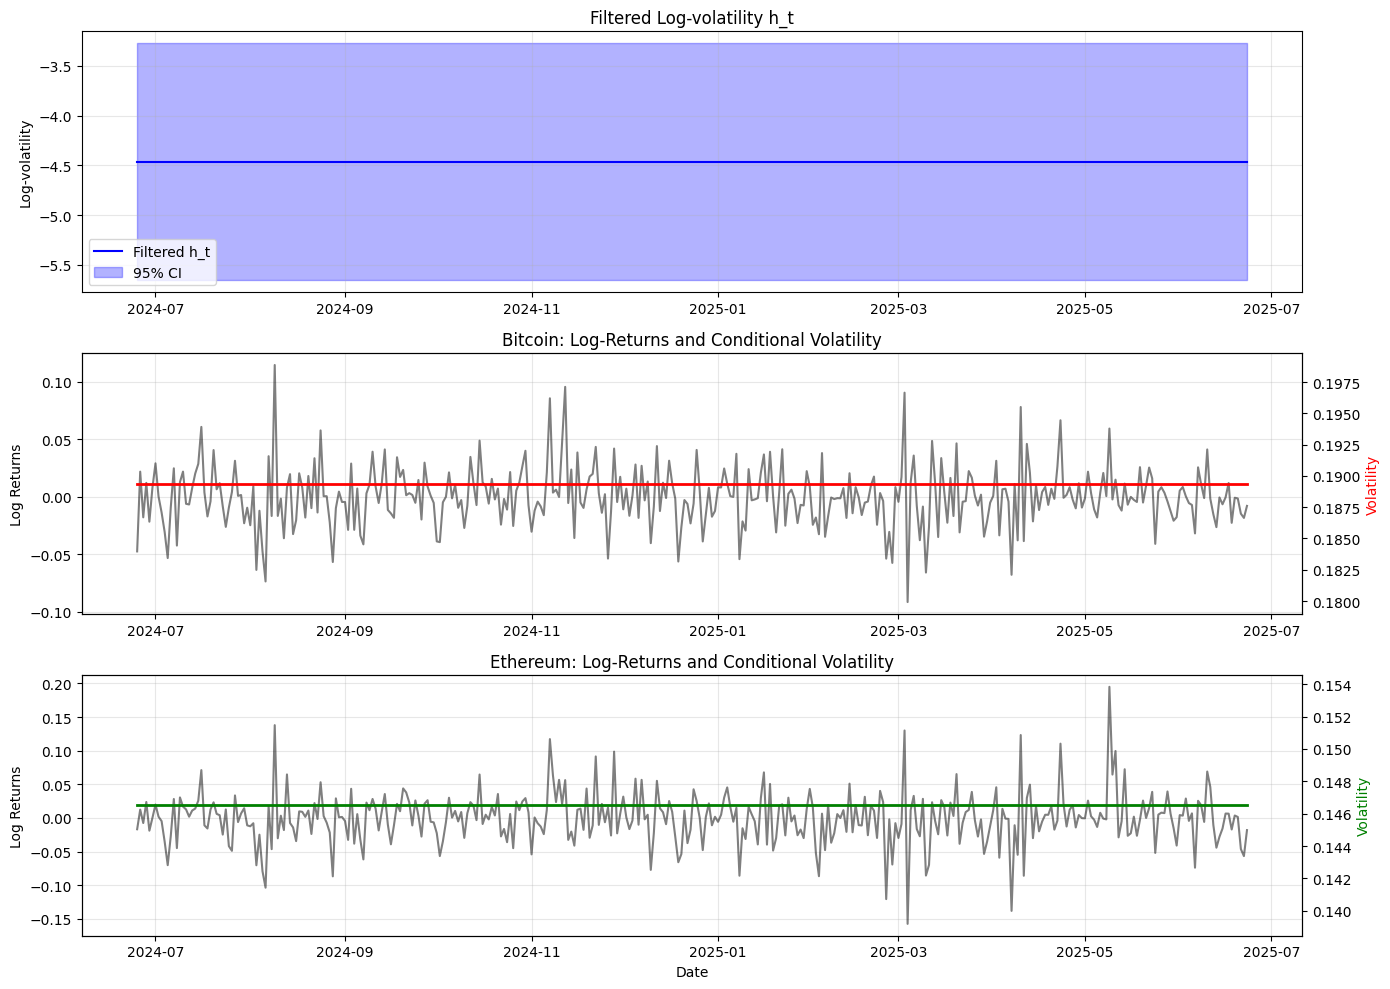


Correlation Statistics:
Mean: 0.3460
Std: 0.0000
Min: 0.3460
Max: 0.3460

VaR Violation Analysis (95% VaR):
BTC - Actual violations: 0, Expected: 18
ETH - Actual violations: 0, Expected: 18
BTC - Violation rate: 0.00%
ETH - Violation rate: 0.00%

Running PMCMC for parameter estimation...
This may take several minutes...


  0%|          | 5/2000 [02:36<17:21:27, 31.32s/it]


KeyboardInterrupt: 

In [51]:
# =============================================================================
# Main Execution
# =============================================================================

def main():
    """Main execution function."""
    # Fetch cryptocurrency data
    print("Fetching BTC and ETH price data...")
    df_prices = fetch_crypto_prices(coins=['bitcoin', 'ethereum'], days=365)
    
    if df_prices is None:
        raise Exception("Failed to fetch price data")
    
    # Compute log-returns
    log_returns = compute_log_returns(df_prices)
    print(f"Data shape: {log_returns.shape}")
    print(f"Date range: {log_returns.index[0]} to {log_returns.index[-1]}")
    
    # Run particle filter with default parameters
    print("\nRunning particle filter with default parameters...")
    default_params = {
        'mu': 0.0, 'phi': 0.98, 'sigma': 0.15, 'd': 0.5,
        'sigma_e1': 0.1, 'sigma_e2': 0.1, 
        'nu1': 5.0, 'nu2': 5.0, 'omega': 5.0
    }
    
    model = AFactorTMSV(log_returns, **default_params)
    pf = run_particle_filter(model, n_particles=1000)
    print(f"Log-likelihood: {pf.logLt:.2f}")
    
    # Extract filtered states
    h_filtered, u_filtered, h_std = extract_states(pf)
    
    # Calculate conditional volatilities
    vol_btc, vol_eth = calculate_conditional_volatilities(h_filtered, u_filtered, default_params)
    
    # Plot results
    plot_results(log_returns, h_filtered, vol_btc, vol_eth, h_std)
    
    # Calculate correlations
    correlations = correlation_analysis(log_returns, h_filtered, default_params)
    print(f"\nCorrelation Statistics:")
    print(f"Mean: {np.nanmean(correlations):.4f}")
    print(f"Std: {np.nanstd(correlations):.4f}")
    print(f"Min: {np.nanmin(correlations):.4f}")
    print(f"Max: {np.nanmax(correlations):.4f}")
    
    # Calculate risk metrics
    risk_metrics = calculate_risk_metrics(log_returns, vol_btc, vol_eth, default_params)
    print(f"\nVaR Violation Analysis (95% VaR):")
    print(f"BTC - Actual violations: {risk_metrics['violations_btc']}, "
          f"Expected: {risk_metrics['expected_violations']}")
    print(f"ETH - Actual violations: {risk_metrics['violations_eth']}, "
          f"Expected: {risk_metrics['expected_violations']}")
    print(f"BTC - Violation rate: {risk_metrics['violation_rate_btc']:.2%}")
    print(f"ETH - Violation rate: {risk_metrics['violation_rate_eth']:.2%}")
    
    # Optional: Run PMCMC
    run_pmcmc = input("\nRun PMCMC parameter estimation? (y/n): ").lower() == 'y'
    
    if run_pmcmc:
        print("\nRunning PMCMC for parameter estimation...")
        print("This may take several minutes...")
        
        pmcmc = PMCMC(log_returns, n_particles=500)
        param_trace, log_lik_trace, acceptance_rate = pmcmc.run(
            n_iter=2000, burn_in=500, thin=5, verbose=True
        )
        
        # Plot diagnostics
        params_df = plot_pmcmc_diagnostics(param_trace, log_lik_trace)
        
        # Use posterior mean parameters
        posterior_mean_params = params_df.mean().to_dict()
        print("\nPosterior mean parameters:")
        for param, value in posterior_mean_params.items():
            print(f"{param}: {value:.4f}")
        
        # Re-run particle filter with posterior mean parameters
        print("\nRunning particle filter with posterior mean parameters...")
        model_posterior = AFactorTMSV(log_returns, **posterior_mean_params)
        pf_posterior = run_particle_filter(model_posterior, n_particles=1000)
        print(f"Log-likelihood: {pf_posterior.logLt:.2f}")
        
        # Extract states and calculate volatilities
        h_filtered_post, u_filtered_post, h_std_post = extract_states(pf_posterior)
        vol_btc_post, vol_eth_post = calculate_conditional_volatilities(
            h_filtered_post, u_filtered_post, posterior_mean_params
        )
        
        # Plot updated results
        plot_results(log_returns, h_filtered_post, vol_btc_post, vol_eth_post, h_std_post)
    
    # Save results
    save_option = input("\nSave results to file? (y/n): ").lower() == 'y'
    
    if save_option:
        # Create results dictionary
        results = {
            'log_returns': log_returns,
            'h_filtered': h_filtered,
            'u_filtered': u_filtered,
            'vol_btc': vol_btc,
            'vol_eth': vol_eth,
            'params': default_params,
            'model_name': 'AFactor-t-MSV'
        }
        
        # If PMCMC was run, update with posterior results
        if run_pmcmc:
            results.update({
                'posterior_params': posterior_mean_params,
                'param_trace': param_trace,
                'h_filtered_posterior': h_filtered_post,
                'u_filtered_posterior': u_filtered_post,
                'vol_btc_posterior': vol_btc_post,
                'vol_eth_posterior': vol_eth_post
            })
        
        # Save as pickle
        filename = 'afactor_tmsv_results.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(results, f)
        
        # Save volatilities as CSV
        vol_df = pd.DataFrame({
            'date': log_returns.index,
            'btc_returns': log_returns['BITCOIN'],
            'eth_returns': log_returns['ETHEREUM'],
            'btc_volatility': vol_btc,
            'eth_volatility': vol_eth,
            'log_volatility': h_filtered
        })
        
        # Add posterior results if available
        if run_pmcmc:
            vol_df['btc_volatility_posterior'] = vol_btc_post
            vol_df['eth_volatility_posterior'] = vol_eth_post
            vol_df['log_volatility_posterior'] = h_filtered_post
        
        csv_filename = 'afactor_tmsv_volatilities.csv'
        vol_df.to_csv(csv_filename, index=False)
        
        print(f"\nResults saved to {filename} and {csv_filename}")
    
    print("\nAnalysis complete!")


if __name__ == "__main__":
    main()